# Analysis of the Human Connectome Project (funcional connectome)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from mlconfound.stats import full_confound_test, partial_confound_test
from mlconfound.plot import plot_graph
from mlconfound.stats import _r2_cat_cont, _r2_cont_cont

from mlxtend.evaluate import permutation_test

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols as ols_f
from scipy.stats import kurtosis, skew

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import quantile_transform

from neurocombat_sklearn import CombatModel

## Load data

In [2]:
# HCP data can be obtained from the connectomeDB with special license
# data is not part of this repository
subjectIDs = pd.read_csv('../data_in/hcp/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('../data_in/hcp/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('../data_in/hcp/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('../data_in/hcp/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,age
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80,23.5
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,28.0


### Select target variable

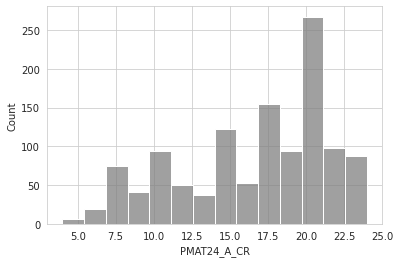

In [3]:
##########################################################
# change these
target = 'PMAT24_A_CR' # fluid intelligence
feature_data = netmats_parcor
##########################################################

sns.histplot(behavior[target], color='gray')
plt.savefig('../data_out/fig/hcp_iq_nonnorm_hist.pdf')

# it's a good practice to use pandas for merging, messing up subject order can be painful
features = feature_data.columns
df = behavior
df = df.merge(feature_data, left_index=True, right_index=True, how='left')
df = df.dropna(subset = [target] + features.values.tolist())
y = df[target].values
X = df[features].values

### Normalize target

/home/tspisak/src/mlconfound/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (999). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


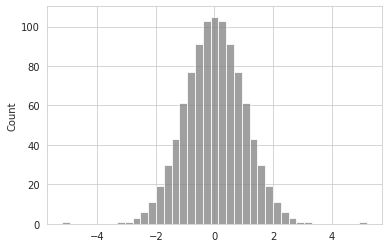

In [4]:
rng = np.random.default_rng(42)
y_trf = quantile_transform(np.array([y+rng.uniform(0,1,len(y))-0.5]).T, output_distribution='normal', n_quantiles=1000).flatten()

sns.histplot(y_trf, color='gray')
plt.savefig('../data_out/fig/hcp_iq_quanttrf_hist.pdf')

kurtosis(y_trf), skew(y_trf)
y=y_trf

# Machine Learning on raw data

In [5]:
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', Ridge(max_iter=100000))])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}


In [6]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))

print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X[train], y[train])

    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))

    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)

    predicted[test] = clf.predict(X[test])

    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__alpha': 100000} -0.9199305094605629 -0.9786879290498208
cv: 1 {'model__alpha': 100000} -0.9077079825659713 -1.0804186751948515
cv: 2 {'model__alpha': 100000} -0.9331575065292255 -0.8310754278190696
cv: 3 {'model__alpha': 10000} -0.8975912683493059 -1.1747262545033739
cv: 4 {'model__alpha': 100000} -0.9269205642606616 -0.8765023704008668
cv: 5 {'model__alpha': 100000} -0.9564344119011106 -0.6325980055959738
cv: 6 {'model__alpha': 10000} -0.9092064303417258 -1.0547858952767655
cv: 7 {'model__alpha': 100000} -0.9124024410173399 -0.9995504450415025
cv: 8 {'model__alpha': 100000} -0.9055768764204947 -1.046954923971703
cv: 9 {'model__alpha': 100000} -0.9442157525601786 -0.7378036764381557


### Results (raw data)

*** Score on mean as model:	-1.0401469064852684
** Mean score in the inner crossvaludation (inner_cv):	-0.9213143743406578
** Mean Nested Crossvalidation Score (outer_cv):	-0.9413103603292082
Explained Variance: 0.09502171812444837
Correlation: 0.30794678318528035


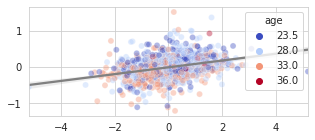

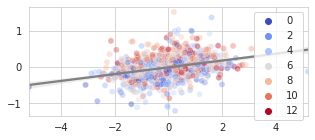

In [7]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.age, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_age_raw_regplot.pdf')
plt.show()

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_acq_raw_regplot.pdf')


## Confound testing: age groups (raw)

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 553.70it/s]


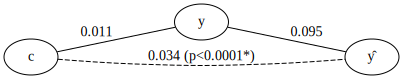

In [8]:
plot_graph(partial_confound_test(y, predicted, df['age'],
                                     random_state=42), outfile_base='../data_out/fig/hcp_age_raw_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 769.34it/s]


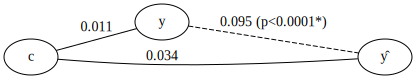

In [9]:
plot_graph(full_confound_test(y, predicted, df['age'],
                                random_state=42), outfile_base='../data_out/fig/hcp_age_raw_full')

In [10]:
nulldist = []
unpermuted = _r2_cont_cont(predicted, df['age'])

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted)
    nulldist.append(_r2_cont_cont(yperm, df['age']))
(nulldist >= unpermuted).sum()/len(nulldist)

0.03376435760825214


0.0

In [11]:
nulldist = []
unpermuted = _r2_cont_cont(y, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cont_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.09483122127416206


0.0

## Confound testing: acquisition batch (raw)

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 434.73it/s]


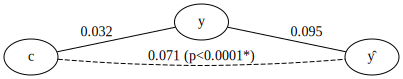

In [12]:
plot_graph(partial_confound_test(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                     random_state=42), outfile_base='../data_out/fig/hcp_acq_raw_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 810.00it/s]


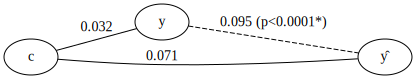

In [13]:
plot_graph(full_confound_test(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                random_state=42), outfile_base='../data_out/fig/hcp_acq_raw_full')

In [14]:
nulldist = []
unpermuted = _r2_cat_cont(pd.Categorical(df['Acquisition'].values).codes, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted)
    nulldist.append(_r2_cat_cont(pd.Categorical(df['Acquisition'].values).codes, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.07074436756038216


0.0

In [15]:
nulldist = []
unpermuted = _r2_cont_cont(y, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cont_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.09483122127416206


0.0

# Regress out confounder from features

In [16]:
# regress-out age from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    OLS_model = OLS(X[:,i], sm.add_constant(df.age)).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

/home/tspisak/src/mlconfound/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [17]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))

print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_adj, y):

    clf.fit(X_adj[train], y[train])

    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))

    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)

    predicted[test] = clf.predict(X_adj[test])

    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 0 {'model__alpha': 100000} -0.9334220737080544 -0.9811146700052953
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 1 {'model__alpha': 100000} -0.91648533677213 -1.1099518410820728
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 2 {'model__alpha': 100000} -0.9439321286581521 -0.854095948403511
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 3 {'model__alpha': 100000} -0.9123236661278243 -1.0922400329908148
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 4 {'model__alpha': 100000} -0.939029578604653 -0.890569892727532
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 5 {'model__alpha': 100000} -0.969579881322978 -0.6317165810350537
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 6 {'model__alpha': 100000} -0.9254465278088257 -0.9626033785574829
Fitting 10 folds for each o

## Results (feature regression)

*** Score on mean as model:	-1.0401469064852684
** Mean score in the inner crossvaludation (inner_cv):	-0.9333780129947481
** Mean Nested Crossvalidation Score (outer_cv):	-0.9355171910218315
Explained Variance: 0.10059128649143256
Correlation: 0.33706125246136165


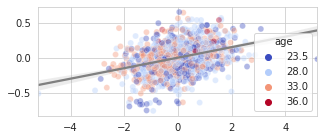

In [18]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.age, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_age_reg_regplot.pdf')

#### Confound test (feature regression)

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 672.44it/s]


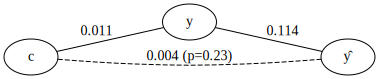

In [19]:
plot_graph(partial_confound_test(y, predicted, df['age'], random_state=42),
          outfile_base='../data_out/fig/hcp_age_reg_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 770.78it/s]


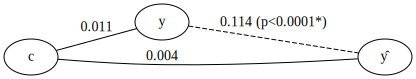

In [20]:
plot_graph(full_confound_test(y, predicted, df['age'], random_state=42),
           outfile_base='../data_out/fig/hcp_age_reg_full')

In [21]:
nulldist = []
unpermuted = _r2_cont_cont(predicted, df['age'])

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted)
    nulldist.append(_r2_cont_cont(yperm, df['age']))
(nulldist >= unpermuted).sum()/len(nulldist)


0.0037082151799741627


0.052

In [22]:
nulldist = []
unpermuted = _r2_cont_cont(y, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cont_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.11361028791082177


0.0

## Regress out acquisition batch

In [23]:
# regress-out acquisition from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    tmp = pd.DataFrame({
        'x': df.Acquisition.values,
        'y': X[:,i]
    })
    OLS_model = ols_f("y ~ C(x)", tmp).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

In [24]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))

print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_adj, y):



    clf.fit(X_adj[train], y[train])


    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))

    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)

    predicted[test] = clf.predict(X_adj[test])

    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 0 {'model__alpha': 100000} -0.9429954500606227 -0.9938514974116519
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 1 {'model__alpha': 100000} -0.9270634172055743 -1.113409812201231
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 2 {'model__alpha': 100000} -0.9558286017680441 -0.845095862250116
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 3 {'model__alpha': 100000} -0.922642621661175 -1.0937701304712275
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 4 {'model__alpha': 100000} -0.9425643730189168 -0.9280262148347256
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 5 {'model__alpha': 100000} -0.9788667555864002 -0.6454127140647611
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 6 {'model__alpha': 100000} -0.9369325275522105 -0.9593783445730694
Fitting 10 folds for eac

## Results (acquisition batch regressed out)

*** Score on mean as model:	-1.0401469064852684
** Mean score in the inner crossvaludation (inner_cv):	-0.9428852244981998
** Mean Nested Crossvalidation Score (outer_cv):	-0.9429915152543401
Explained Variance: 0.09340545131189537
Correlation: 0.32441943682770474


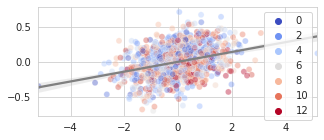

In [25]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_acq_reg_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 400.51it/s]


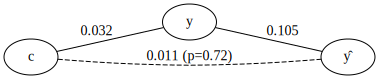

In [26]:
plot_graph(partial_confound_test(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                    random_state=42), outfile_base='../data_out/fig/hcp_acq_reg_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 646.12it/s]


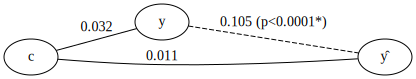

In [27]:
plot_graph(full_confound_test(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                random_state=42), outfile_base='../data_out/fig/hcp_acq_reg_full')


In [28]:
nulldist = []
unpermuted = _r2_cat_cont(pd.Categorical(df['Acquisition'].values).codes, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted)
    nulldist.append(_r2_cat_cont(pd.Categorical(df['Acquisition'].values).codes, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.011397148317779715


0.477

In [29]:
nulldist = []
unpermuted = _r2_cont_cont(y, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cont_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.10524797099160511


0.0

# COMBAT age group

In [30]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))

print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([df.age.astype("category").cat.codes.values[train]]).transpose()
                                  )

    clf.fit(X_train_combat, y[train])

    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([df.age.astype("category").cat.codes.values[test]]).transpose()
                                  )

    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))

    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)

    predicted[test] = clf.predict(X_test_combat)

    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 0 {'model__alpha': 100000} -0.9300734267643153 -0.9791533004119743
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 1 {'model__alpha': 100000} -0.9131055057865348 -1.0955185128924585
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 2 {'model__alpha': 100000} -0.9421503042907181 -0.8421133071431006
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 3 {'model__alpha': 100000} -0.9052915262330439 -1.093635458840644
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 4 {'model__alpha': 100000} -0.9358114340313142 -0.8800433698774458
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 5 {'model__alpha': 100000} -0.9654616482430806 -0.6332270934227769
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 6 {'model__alpha': 100000} -0.9226200142826684 -0.9589841130615672
Fitting 10 folds for e

## Results (combat age)

*** Score on mean as model:	-1.0401469064852684
** Mean score in the inner crossvaludation (inner_cv):	-0.9295784263698934
** Mean Nested Crossvalidation Score (outer_cv):	-0.929334765930095
Explained Variance: 0.1065350864039154
Correlation: 0.3483917910413174


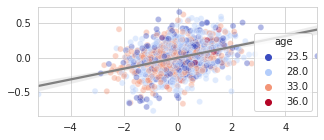

In [31]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.age,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_age_comb_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 748.24it/s]


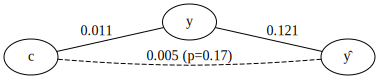

In [32]:
plot_graph(partial_confound_test(y, predicted, df['age'], random_state=42),
          outfile_base='../data_out/fig/hcp_age_comb_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 799.25it/s]


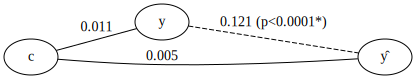

In [33]:
plot_graph(full_confound_test(y, predicted, df['age'], random_state=42),
          outfile_base='../data_out/fig/hcp_age_comb_full')

In [34]:
nulldist = []
unpermuted = _r2_cont_cont(predicted, df['age'])

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted)
    nulldist.append(_r2_cont_cont(yperm, df['age']))
(nulldist >= unpermuted).sum()/len(nulldist)

0.004605027973265126


0.048

In [35]:
nulldist = []
unpermuted = _r2_cont_cont(y, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cont_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)



0.12137684006497697


0.0

# COMBAT acquisition batch

In [36]:
# nested cv
outer_cv = KFold(10)
inner_cv = KFold(10)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))

print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([df.Acquisition.astype("category").cat.codes.values[train]]).transpose()
                                  )

    clf.fit(X_train_combat, y[train])

    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([df.Acquisition.astype("category").cat.codes.values[test]]).transpose()
                                  )

    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))

    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)

    predicted[test] = clf.predict(X_test_combat)

    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 0 {'model__alpha': 100000} -0.9316398231156893 -0.9849466200542852
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 1 {'model__alpha': 100000} -0.9179827759720558 -1.0920181844748902
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 2 {'model__alpha': 100000} -0.9458686166388015 -0.8344682629982223
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 3 {'model__alpha': 100000} -0.9128137505056617 -1.09082738592428
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 4 {'model__alpha': 100000} -0.9343641987503577 -0.8974868073172718
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 5 {'model__alpha': 100000} -0.9684187812749412 -0.6392219529925428
Fitting 10 folds for each of 11 candidates, totalling 110 fits
cv: 6 {'model__alpha': 100000} -0.9266692657483278 -0.9543780082047695
Fitting 10 folds for ea

## Results (combat acquisition batch)

*** Score on mean as model:	-1.0401469064852684
** Mean score in the inner crossvaludation (inner_cv):	-0.9335476209721069
** Mean Nested Crossvalidation Score (outer_cv):	-0.9297502512682309
Explained Variance: 0.10613563769571344
Correlation: 0.3494477666465382


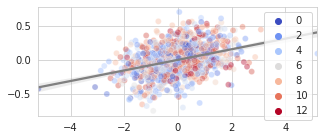

In [37]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))

sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../data_out/fig/hcp_acq_comb_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 411.34it/s]


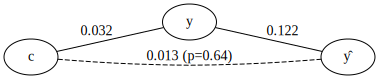

In [38]:
plot_graph(partial_confound_test(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                    random_state=42), outfile_base='../data_out/fig/hcp_acq_comb_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 746.27it/s]


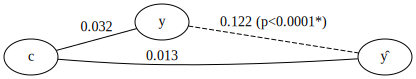

In [39]:
plot_graph(full_confound_test(y, predicted, pd.Categorical(df['Acquisition'].values).codes, cat_c=True,
                                random_state=42), outfile_base='../data_out/fig/hcp_acq_comb_full')


In [40]:
nulldist = []
unpermuted = _r2_cat_cont(pd.Categorical(df['Acquisition'].values).codes, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cat_cont(pd.Categorical(df['Acquisition'].values).codes, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.012865644754609495


0.401

In [41]:
nulldist = []
unpermuted = _r2_cont_cont(y, predicted)

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(predicted)
    nulldist.append(_r2_cont_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.12211374161425342


0.0

In [42]:
nulldist = []
unpermuted = _r2_cont_cont(y, df['age'])

print(unpermuted)

for i in range(1000):
    yperm = np.random.\
        permutation(y)
    nulldist.append(_r2_cont_cont(yperm, df['age']))
(nulldist >= unpermuted).sum()/len(nulldist)





0.010731881875548643


0.0

In [43]:
nulldist = []
unpermuted = _r2_cat_cont(df['Acquisition'], y)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(y)
    nulldist.append(_r2_cat_cont(df['Acquisition'], yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.031726862731525474


0.001